This notebook demonstrates how to calculate and plot eFold distance of inter-site temperature correlation using the eFold module. The source data for this example is the LiPD dataset from http://lipdverse.org/Temp12K/current_version.

The source code in the notebook converts the LiPD dataset into a set of times and temperatures, then uses the eFold module to filter the dataset, calculate the correlations between sites, then calculate and plot the eFold distances between the correlations.



In [10]:
#import system packages
import lipd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
import sys

In [2]:
#import local modules
from eFold import binTime
from eFold import bandPassFilter
from eFold import binAndFilter
from eFold import eFoldingDistance
from eFold import calcEFold
from eFold import plotMap


In [3]:
# Load the pickled LiPD dataset
pickleFidIn = 'Temp12k1_0_1.pkl'
lipdData = pickle.load(open(pickleFidIn,'rb'))

# Extract the temp12K Time Series
tsList = lipd.filterTs(lipdData['TS'],'paleoData_inCompilation == Temp12k')

Found 1319 matches from 5088 columns


In [4]:
# Choose the record for each unique site/proxy type
# that has the best averaging across years. Earlier in list is preferred.
#
validSeasons = ['annual','summeronly', 'winteronly','summer+']
allSites = {}

In [5]:
for site in tsList:
    siteRecord = {}
    siteName = site['geo_siteName']
    siteProxy = site['paleoData_proxy']
    siteLat = site['geo_meanLat']
    siteLon = site['geo_meanLon']

    for interpretation in site['paleoData_interpretation']:
        # Extract season
        if 'seasonalityGeneral' in interpretation:
            season = interpretation['seasonalityGeneral'].lower()
        elif 'seasonality' in interpretation:
            season = interpretation['seasonality'].lower()
        else:
            continue


        # Make sure season is a valid annual average
        if season in validSeasons:
            siteRecord['sitename'] = siteName
            siteRecord['proxy'] = siteProxy
            siteRecord['longitude'] = siteLon
            siteRecord['season'] = season
            siteRecord['latitude'] = siteLat
            siteRecord['longitude'] = siteLon

            # Convert age from years BP to year, include 'nan'
            ages = [np.nan if age=='nan' else age for age in site['age']]
            times = [1950.0-age for age in ages]

            # Get mean temperature values
            temps = [np.nan if val=='nan' else val for val in site['paleoData_values']]
            temps = temps - np.mean(temps)

            # Remove records from times and temps if time is NaN
            nonNanIdx = ~np.isnan(times)
            siteRecord['times'] = np.asarray(times)[nonNanIdx]
            siteRecord['temps'] = np.asarray(temps)[nonNanIdx]

            # Add record if not already in dict
            if (siteName,siteProxy) not in allSites:
                allSites[(siteName,siteProxy)] = siteRecord
            else:
            # Replace record if this season is higher ranked
                existingRecord = allSites[(siteName,siteProxy)]
                existingSeason = existingRecord['season']
                if validSeasons.index(season) < validSeasons.index(existingSeason):
                    allSites[(siteName,siteProxy)] = siteRecord

In [6]:
siteList = []
for key, value in allSites.items():
    siteName = key[0]
    proxy = key[1]
    siteList.append(allSites[(siteName,proxy)])

print('Num sites',len(siteList))


Num sites 794


In [7]:
# bin all the temperatures into 100-year groups, and filter out the low frequency repetitions
filteredArray = binAndFilter( siteList, timeStart=-12000,timeEnd=2000,timeStep=100,highBandPass=True,replaceNaN=False,bandPassCutoff=10)

In [8]:
# Calculate correlations between each pair of sites and the eFold distance for each site
eFold = calcEFold( siteList, filteredArray, minPeriods=4 )

/home/brent/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/brent/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/brent/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


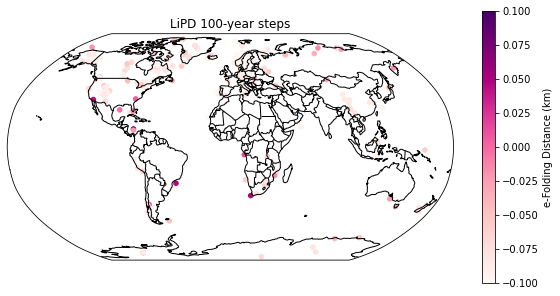

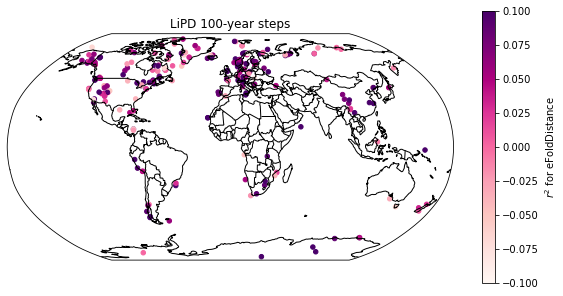

In [12]:

# Plot the data on a map
# Put the data into usable lists                     
lons = []                                            
lats = []                                            
r2 = []                                              
eFoldDistance = []                                   
for i in range(0,len(eFold)):                        
    lons.append(eFold[i]['lon'])                     
    lats.append(eFold[i]['lat'])
    r2.append(eFold[i]['r2'])
    eFoldDistance.append(eFold[i]['eFoldDistance'])

plt.rcParams['figure.figsize']=[10,5]
plotMap( lats, lons, eFoldDistance,plotTitle='LiPD 100-year steps',dataLabel='e-Folding Distance (km)',dotSize=20 )
plotMap( lats, lons,r2,plotTitle='LiPD 100-year steps',dataLabel='$r^2$ for eFoldDistance',dotSize=20)  
